## 课程基本信息

- **课程名称**：大数据与商务智能 - 模型上下文协议（MCP）开发实战
- **授课对象**：中山大学工商管理非全专硕MBA学生
- **课时**：3学时（上机课）
- **前置知识**：基础Python编程能力，LLM基础应用能力，RAG检索技术

完成本课程后，您将能够：
1. 使用LangChain框架实现标准化函数调用与多工具协作
2. 设计并开发符合MCP规范的服务端与客户端应用
3. 调试和优化智能体系统性能与可靠性
4. 部署面向实际业务场景的多智能体协作系统


## 3.1 MCP协议基础

### 3.1.1 协议设计理念
MCP（Model Context Protocol）旨在解决以下问题：
- 不同LLM智能体间通信标准不统一
- 函数调用参数格式混乱
- 多智能体协作流程难以管理
- 上下文状态维护复杂

### 3.1.2 与前序课程关系
| 技术点 | LLM课程 | RAG课程 | MCP课程 |
|-------|---------|---------|---------|
| 函数调用 | 基础实现 | 检索工具调用 | 标准化协议 |
| 上下文管理 | 单轮对话 | 检索结果整合 | 多轮状态跟踪 |
| 多工具协作 | 简单集成 | 检索+生成 | 智能体网络 |

### 3.1.3 协议核心概念
MCP（Model Context Protocol）定义了智能体间通信的标准格式和交互规则，主要包含：
- **会话管理**：跟踪智能体交互状态
- **函数注册**：标准化函数定义与参数
- **消息格式**：统一智能体间通信内容结构
- **错误处理**：规范异常情况处理机制

### 3.1.4 智能体通信模型

```
[智能体A] → [MCP消息] → [智能体B]
   ↑                          ↓
[响应结果] ← [MCP消息] ← [处理请求]
```

In [ ]:
import uvicorn

## 3.2 MCP代码实现

### 3.2.1 MCP服务端实现

`mcp_full.py`：

In [ ]:
from fastapi import FastAPI, HTTPException
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel, Field
from typing import Dict, Any, Optional, Callable, List
import uuid
from datetime import datetime, timedelta
import requests
import json
from functools import wraps

# ==== 服务端实现 ====
app = FastAPI(
    title="模型上下文协议(MCP)服务",
    description="企业级LLM智能体交互协议服务",
    version="1.0.0"
)

app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

# 数据模型
class SessionCreateRequest(BaseModel):
    client_id: str = Field(..., description="客户端ID")
    user_id: Optional[str] = Field(None, description="用户ID")
    session_timeout: int = Field(3600, description="会话超时时间(秒)")

class FunctionDefinition(BaseModel):
    name: str = Field(..., description="函数名称")
    description: str = Field(..., description="函数描述")
    parameters: List[Dict[str, Any]] = Field(..., description="参数列表")

class FunctionCallRequest(BaseModel):
    session_id: str = Field(..., description="会话ID")
    function_name: str = Field(..., description="函数名称")
    parameters: Dict[str, Any] = Field(..., description="函数参数")

# 内存存储
sessions = {}
function_registry = {}

# 核心功能
def register_function(func: Callable, definition: FunctionDefinition):
    """注册函数到MCP服务"""
    function_registry[definition.name] = {
        "func": func,
        "definition": definition.dict()
    }

@app.post("/sessions", summary="创建新会话")
async def create_session(request: SessionCreateRequest):
    """创建新的MCP会话"""
    session_id = str(uuid.uuid4())
    expires_at = datetime.utcnow() + timedelta(seconds=request.session_timeout)
    
    sessions[session_id] = {
        "session_id": session_id,
        "client_id": request.client_id,
        "user_id": request.user_id,
        "expires_at": expires_at,
        "timeout": request.session_timeout,
        "history": []
    }
    
    return {
        "session_id": session_id,
        "expires_at": expires_at,
        "status": "active"
    }

@app.post("/functions/call", summary="调用函数")
async def call_function(request: FunctionCallRequest):
    """调用注册的MCP函数"""
    if request.session_id not in sessions:
        raise HTTPException(status_code=404, detail=f"Session {request.session_id} not found")
    
    if request.function_name not in function_registry:
        raise HTTPException(status_code=404, detail=f"Function {request.function_name} not registered")
    
    # 执行函数
    func_info = function_registry[request.function_name]
    try:
        result = func_info["func"](**request.parameters)
        
        # 记录调用历史
        sessions[request.session_id]["history"].append({
            "timestamp": datetime.utcnow(),
            "function": request.function_name,
            "parameters": request.parameters,
            "result": result
        })
        
        return {
            "session_id": request.session_id,
            "function_name": request.function_name,
            "result": result,
            "timestamp": datetime.utcnow()
        }
    except Exception as e:
        return {
            "session_id": request.session_id,
            "function_name": request.function_name,
            "error": str(e),
            "timestamp": datetime.utcnow()
        }

# ==== 业务函数 ====
# 客户分群函数
def customer_segmentation(revenue: float, frequency: int, recency: int) -> str:
    """基于RFM模型的客户分群"""
    if recency < 30 and frequency > 12 and revenue > 10000:
        return "高价值客户"
    elif recency < 60 and frequency > 6 and revenue > 5000:
        return "增长型客户"
    elif recency > 180 and frequency < 3 and revenue < 1000:
        return "流失风险客户"
    else:
        return "一般价值客户"

# 销售预测函数
def sales_forecast(segment: str, budget: float) -> str:
    """基于客户分群和营销预算的销售预测"""
    base_growth = {
        "高价值客户": 0.15, "增长型客户": 0.25,
        "一般价值客户": 0.08, "流失风险客户": 0.30
    }
    growth_rate = base_growth.get(segment, 0.05)
    budget_impact = min(budget / 1000 * 0.01, 0.2)
    total_growth = growth_rate + budget_impact
    return f"{total_growth*100:.1f}%"

# 注册业务函数
register_function(
    func=customer_segmentation,
    definition=FunctionDefinition(
        name="customer_segmentation",
        description="基于RFM模型的客户分群函数",
        parameters=[
            {"name": "revenue", "type": "float", "description": "客户年度消费金额", "required": True},
            {"name": "frequency", "type": "int", "description": "客户年度购买频次", "required": True},
            {"name": "recency", "type": "int", "description": "最近购买天数", "required": True}
        ]
    )
)

register_function(
    func=sales_forecast,
    definition=FunctionDefinition(
        name="sales_forecast",
        description="基于客户分群和营销预算的销售预测函数",
        parameters=[
            {"name": "segment", "type": "string", "description": "客户分群结果", "required": True},
            {"name": "budget", "type": "float", "description": "营销预算金额", "required": True}
        ]
    )
)

# ==== 客户端实现 ====
class MCPClient:
    """MCP协议客户端"""
    
    def __init__(self, base_url: str, client_id: str):
        self.base_url = base_url.rstrip("/")
        self.client_id = client_id
        self.session_id = None
        self.headers = {"Content-Type": "application/json"}
    
    def create_session(self, user_id: Optional[str] = None, timeout: int = 3600) -> dict:
        """创建MCP会话"""
        response = requests.post(
            f"{self.base_url}/sessions",
            headers=self.headers,
            json={
                "client_id": self.client_id,
                "user_id": user_id,
                "session_timeout": timeout
            }
        )
        result = response.json()
        self.session_id = result.get("session_id")
        return result
    
    def call_function(self, function_name: str, parameters: Dict[str, Any]) -> dict:
        """调用MCP函数"""
        if not self.session_id:
            raise ValueError("请先创建会话")
            
        response = requests.post(
            f"{self.base_url}/functions/call",
            headers=self.headers,
            json={
                "session_id": self.session_id,
                "function_name": function_name,
                "parameters": parameters
            }
        )
        return response.json()

# ==== 启动服务 ====
if __name__ == "__main__":
    import nest_asyncio
    nest_asyncio.apply()  # Patch event loop for Jupyter compatibility
    import uvicorn
    uvicorn.run(app, host="0.0.0.0", port=8000)

如果你直接运行了上方代码块，要么它会一直运行并阻断后续代码的执行，要么它会直接报错退出。这是正常的，不必惊慌。

实际上，我们不能直接在Jupyter中运行上方代码块，因为这不符合MCP“服务”的性质。我们需要通过3.2.2的两种方法来启动MCP服务，并使用客户端测试功能。

### 3.2.2 MCP客户端调用

MCP服务是通过网络协议提供功能的，因此只有在MCP服务器启动时客户端才能正常使用。此处的网络协议既可以用于远程端口的连接，也可以用于本机内部端口的连接。

3.1.1中的服务端代码实质上会使用本地端口`8000`启动一个HTTP服务器，因此理论上MCP客户端可以通过连接`http://localhost:8000`来访问该服务，有关端口、协议的知识可参考计算机网络和通信原理。

在本教程中，我们提供了两种方式来启动MCP服务器以供客户端调用：其中，正常调用服务时需要使用3.2.2.1的分步方法启动MCP服务器以持续性地提供服务；而快速测试服务端则可以使用3.2.2.2的快速测试方法。

#### 3.2.2.1 分步启动MCP服务端和客户端

##### 3.2.2.1.1 启动MCP服务端

1. 在本讲义目录下新建`mcp_full.py`文件
2. 复制3.2.1节中代码块代码，粘贴到`mcp_full.py`文件中并保存
3. 启动服务器（注意下面的两种方法除非手动结束，否则服务器会一直运行）
    - 方法1：使用debug方法启动服务器

        使用vs code打开`mcp_full.py`文件，检查python环境一致，按F5后选择`Python File`，即可启动服务器

        结束运行方法：点击弹出长条窗口中红色的停止按钮

    - 方法2：使用命令行启动服务器

        在命令行中进入`mcp_full.py`文件所在目录，逐行运行以下命令启动服务器：
        ```bash
        conda activate < mcp环境名称 >
        cd < mcp_full.py文件所在目录 >
        python mcp_full.py
        ```

        结束运行方法：在命令行中按`Ctrl + C`组合键

##### 3.2.2.1.2 启动MCP客户端

完成3.2.2.1.1后，运行下方代码块，以测试MCP客户端调用功能

In [ ]:
import mcp_full
client = mcp_full.MCPClient('http://localhost:8000', 'test_client')
client.create_session()
print(client.call_function('customer_segmentation', {'revenue': 8000, 'frequency': 8, 'recency': 45}))
print(client.call_function('sales_forecast', {'segment': '增长型客户', 'budget': 5000}))

若出现类似下列输出即正常：

```python
{'session_id': 'b8c3c634-bf13-4b96-977a-b35e0dfcacbb', 'function_name': 'customer_segmentation', 'result': '增长型客户', 'timestamp': 'YYYY-MM-DDThh:mm:ss.ssssss'}
{'session_id': 'b8c3c634-bf13-4b96-977a-b35e0dfcacbb', 'function_name': 'sales_forecast', 'result': '30.0%', 'timestamp': 'YYYY-MM-DDThh:mm:ss.ssssss'}
```

#### 3.2.2.2 即时启动MCP服务端和客户端

如果我们只是想即用即弃地测试MCP服务端功能，可以使用下方代码块快速启动MCP服务器并调用客户端进行测试。运行该代码块后，MCP服务器会在代码块执行期间启动，代码块执行结束后服务器会自动关闭。

In [ ]:
!python -c "from mcp_full import MCPClient; client=MCPClient('http://localhost:8000', 'test_client'); client.create_session(); print(client.call_function('customer_segmentation', {'revenue':8000, 'frequency':8, 'recency':45}))"

若出现类似下列输出即正常：

```python
{'session_id': 'b8c3c634-bf13-4b96-977a-b35e0dfcacbb', 'function_name': 'customer_segmentation', 'result': '增长型客户', 'timestamp': 'YYYY-MM-DDThh:mm:ss.ssssss'}
```

### 3.2.3 在Docker中运行MCP服务*（仅作了解）

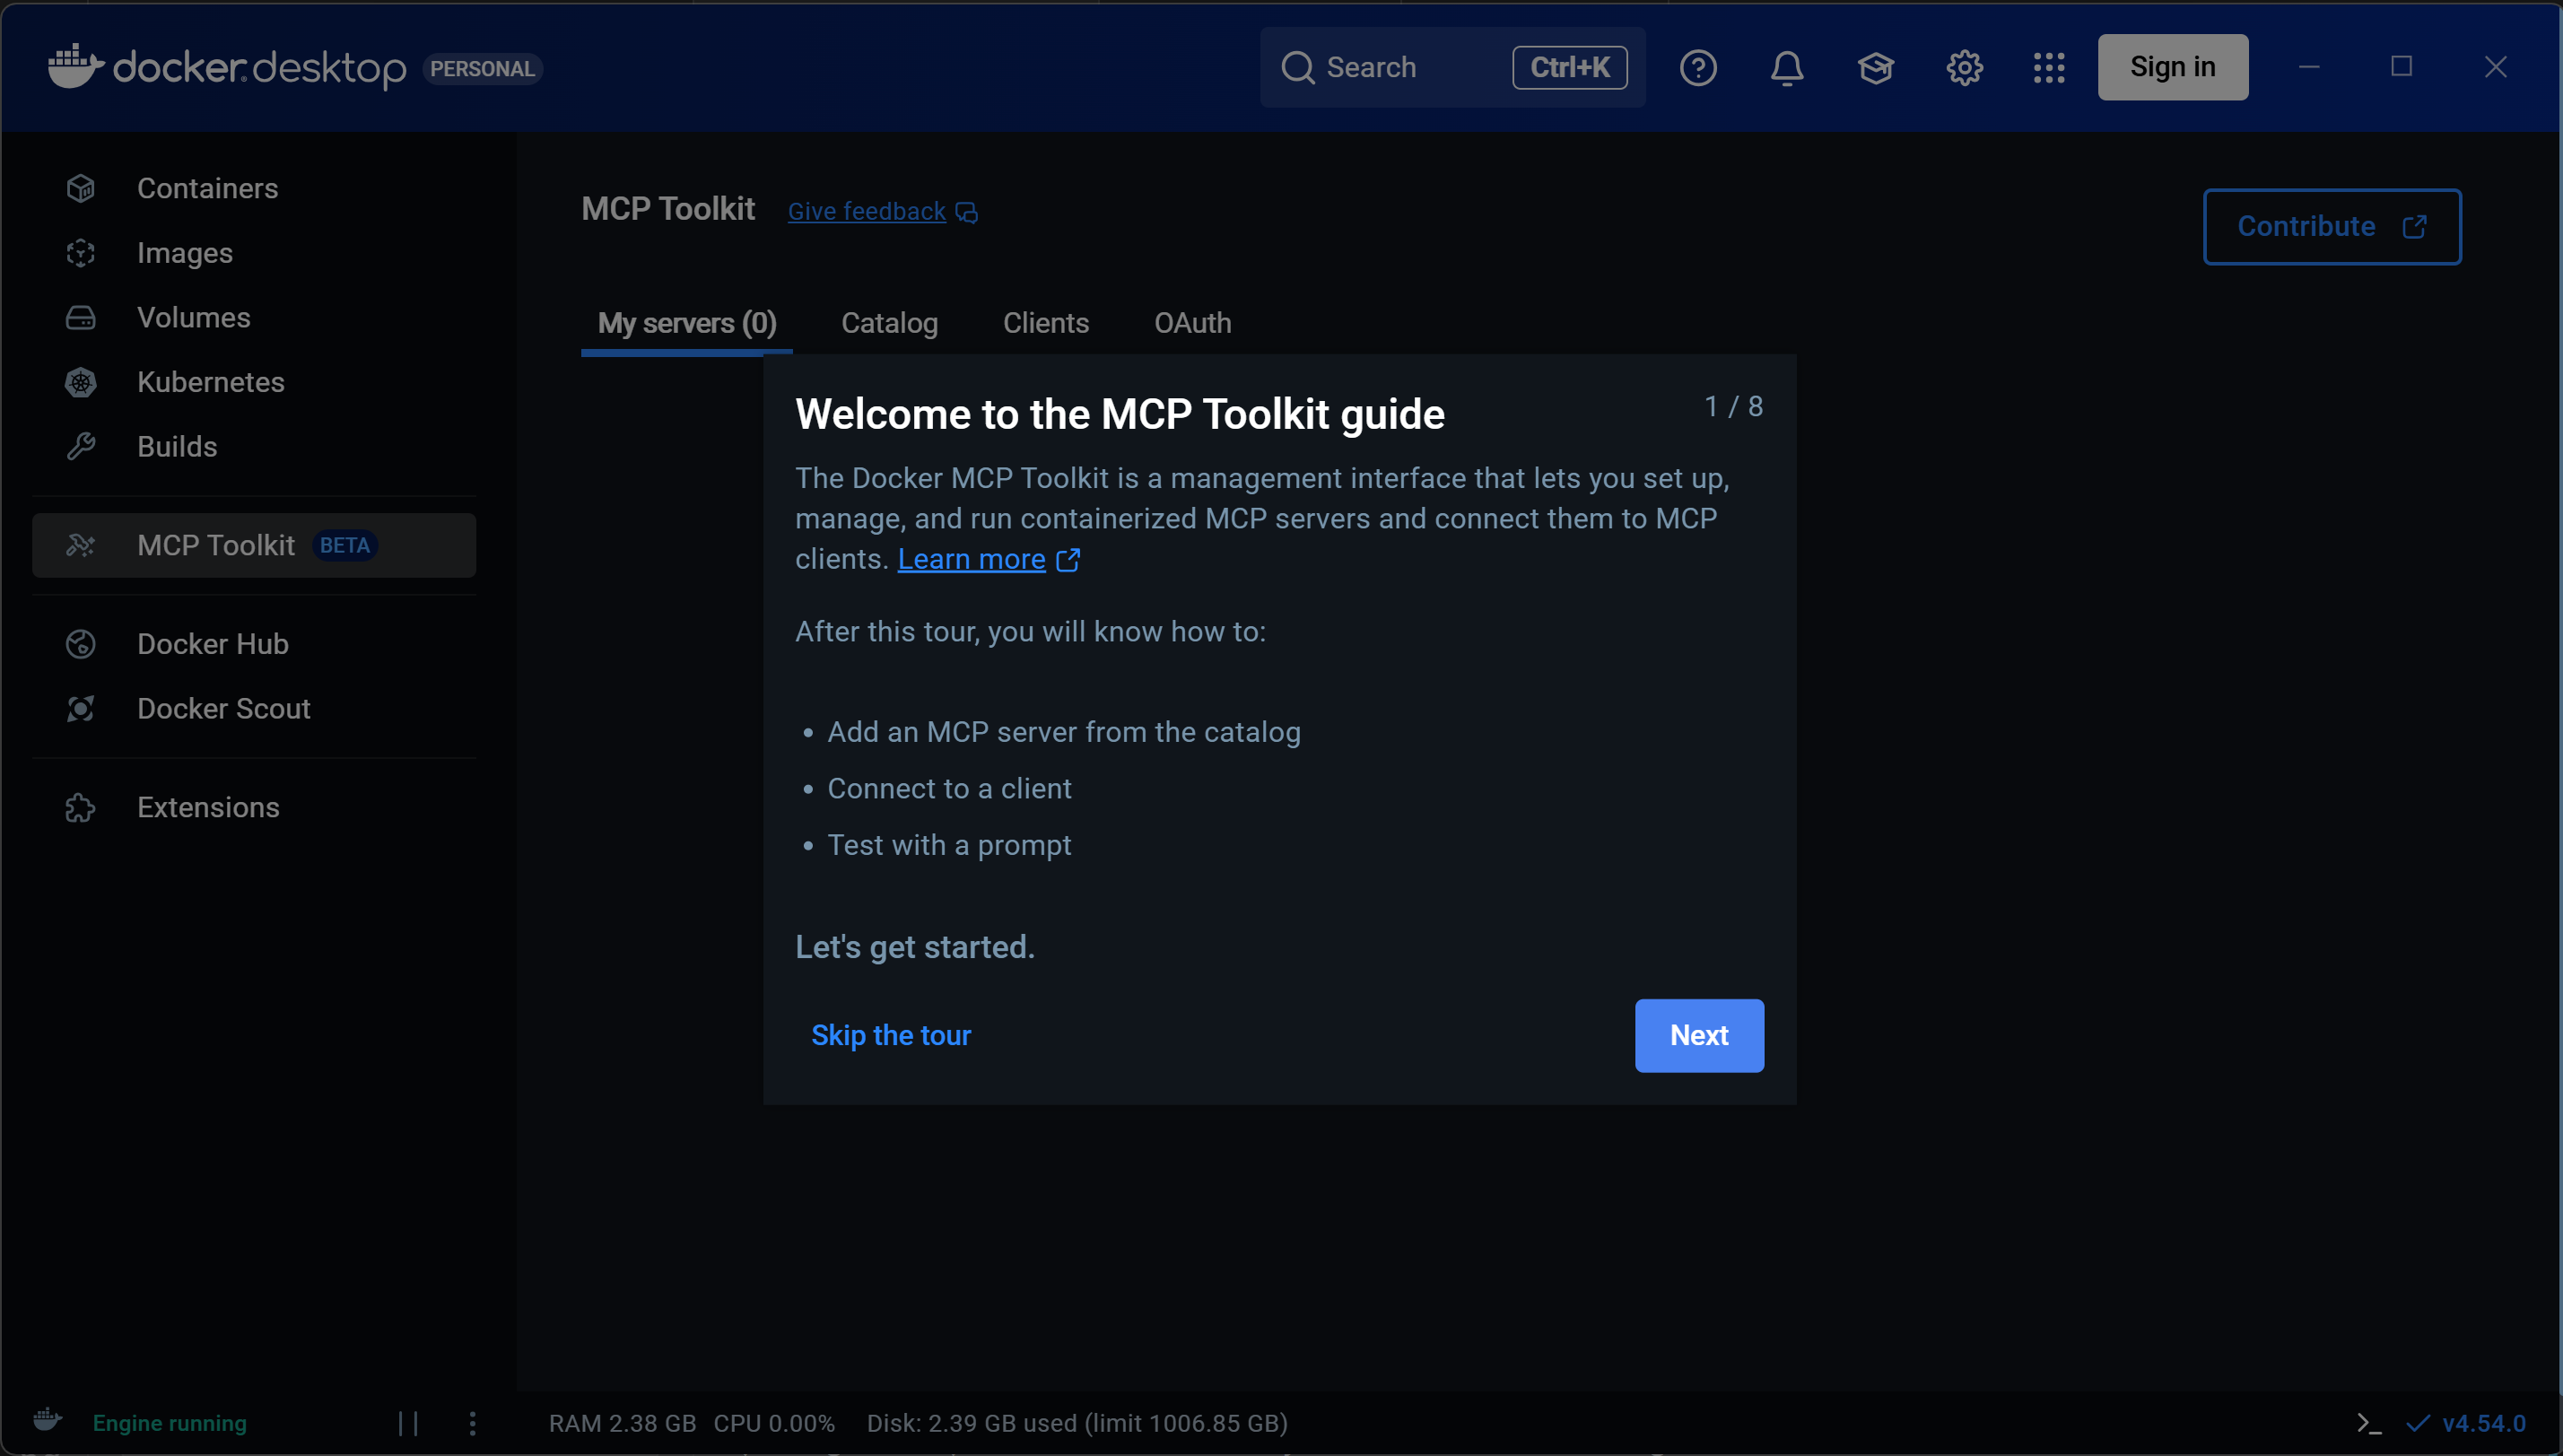
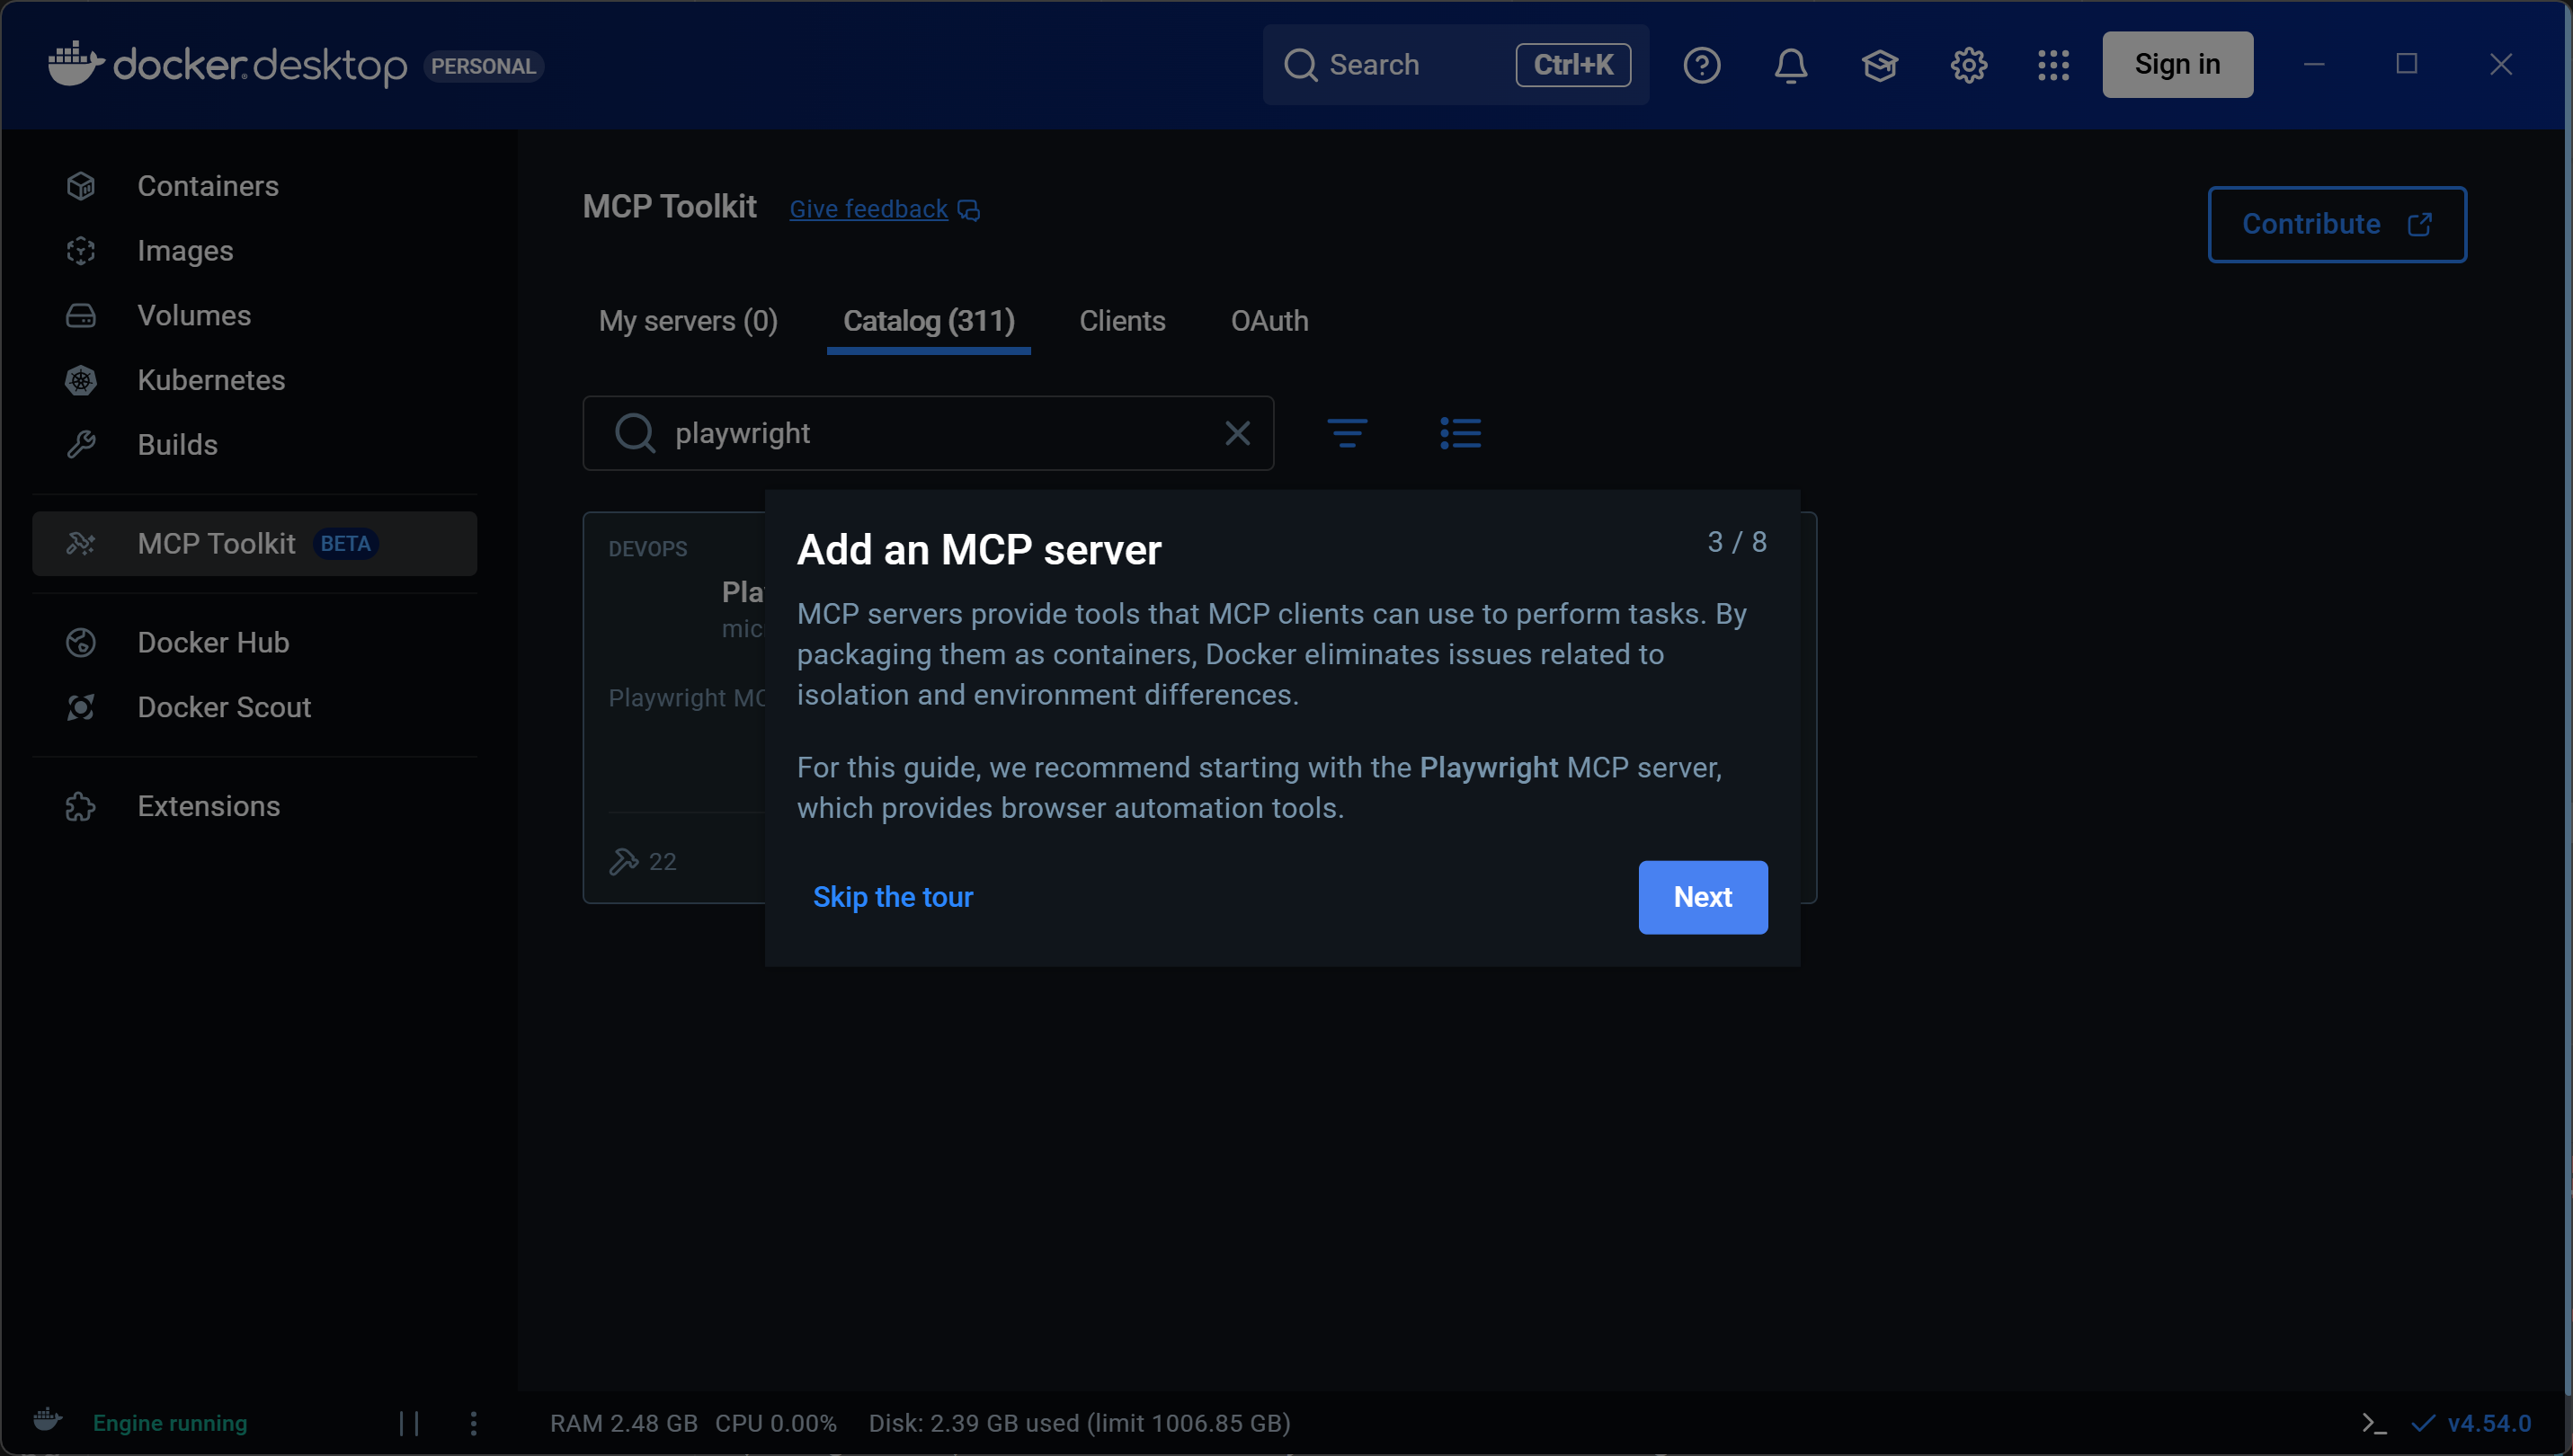
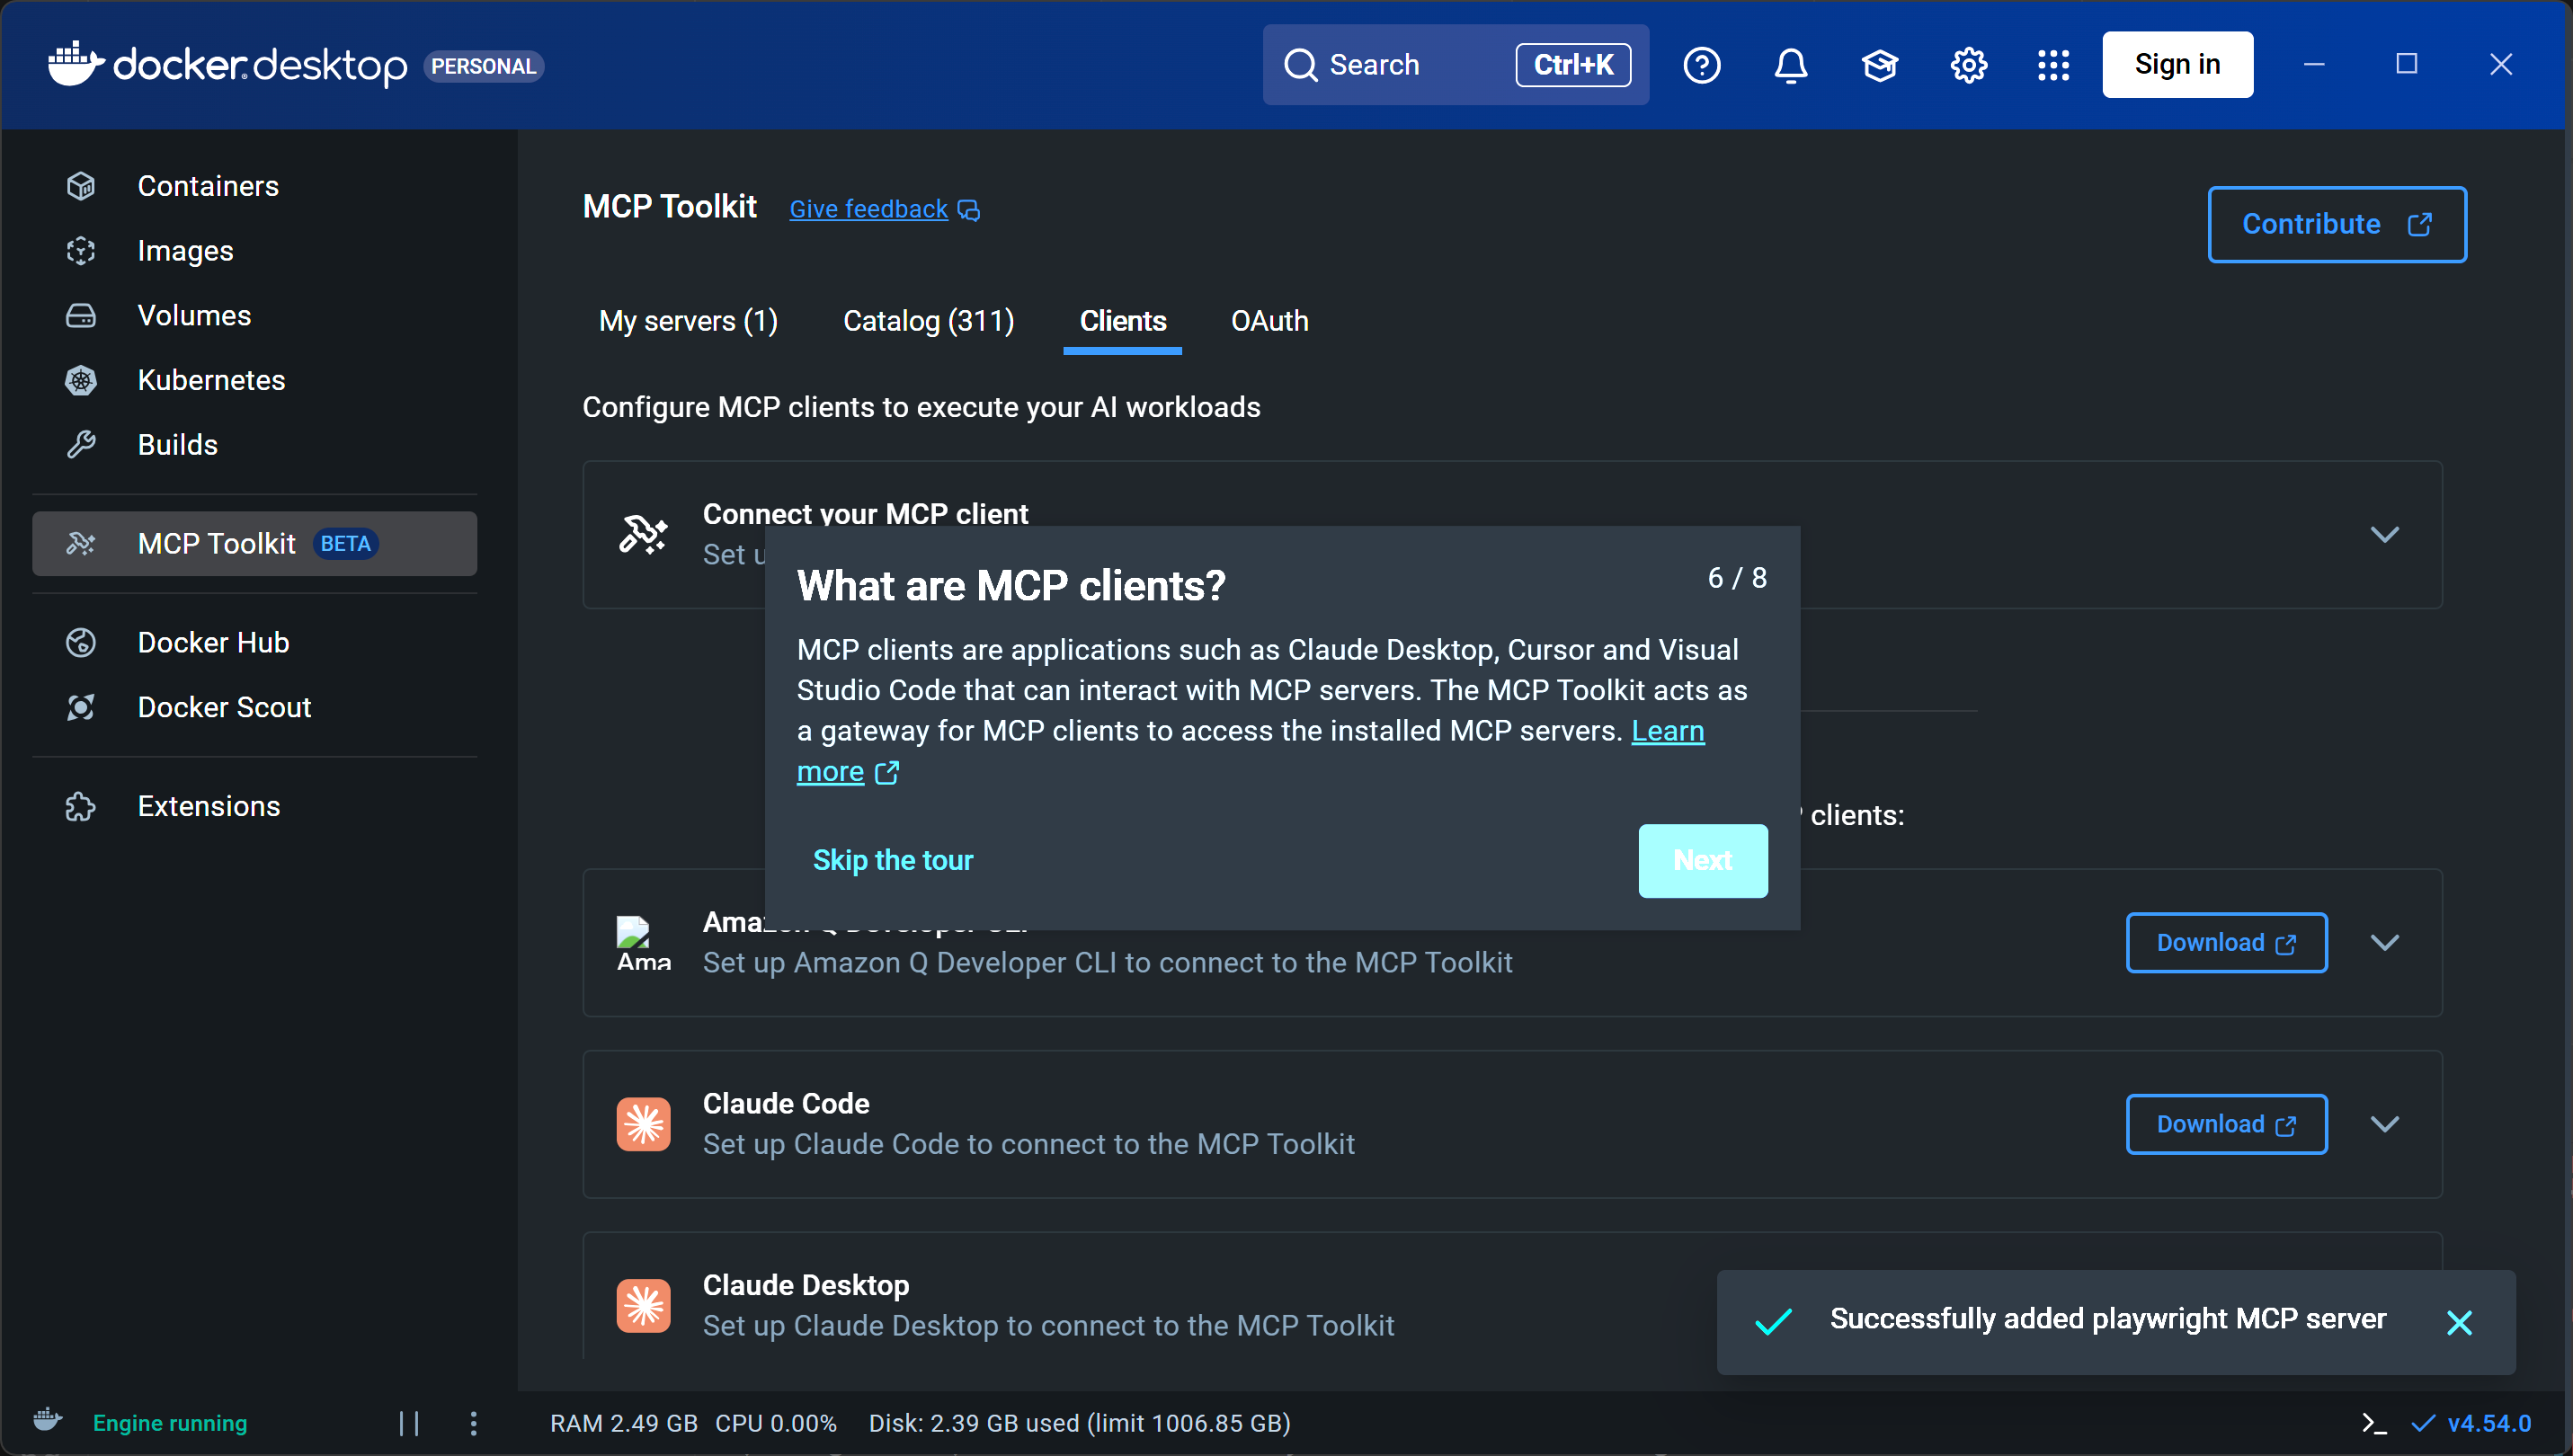
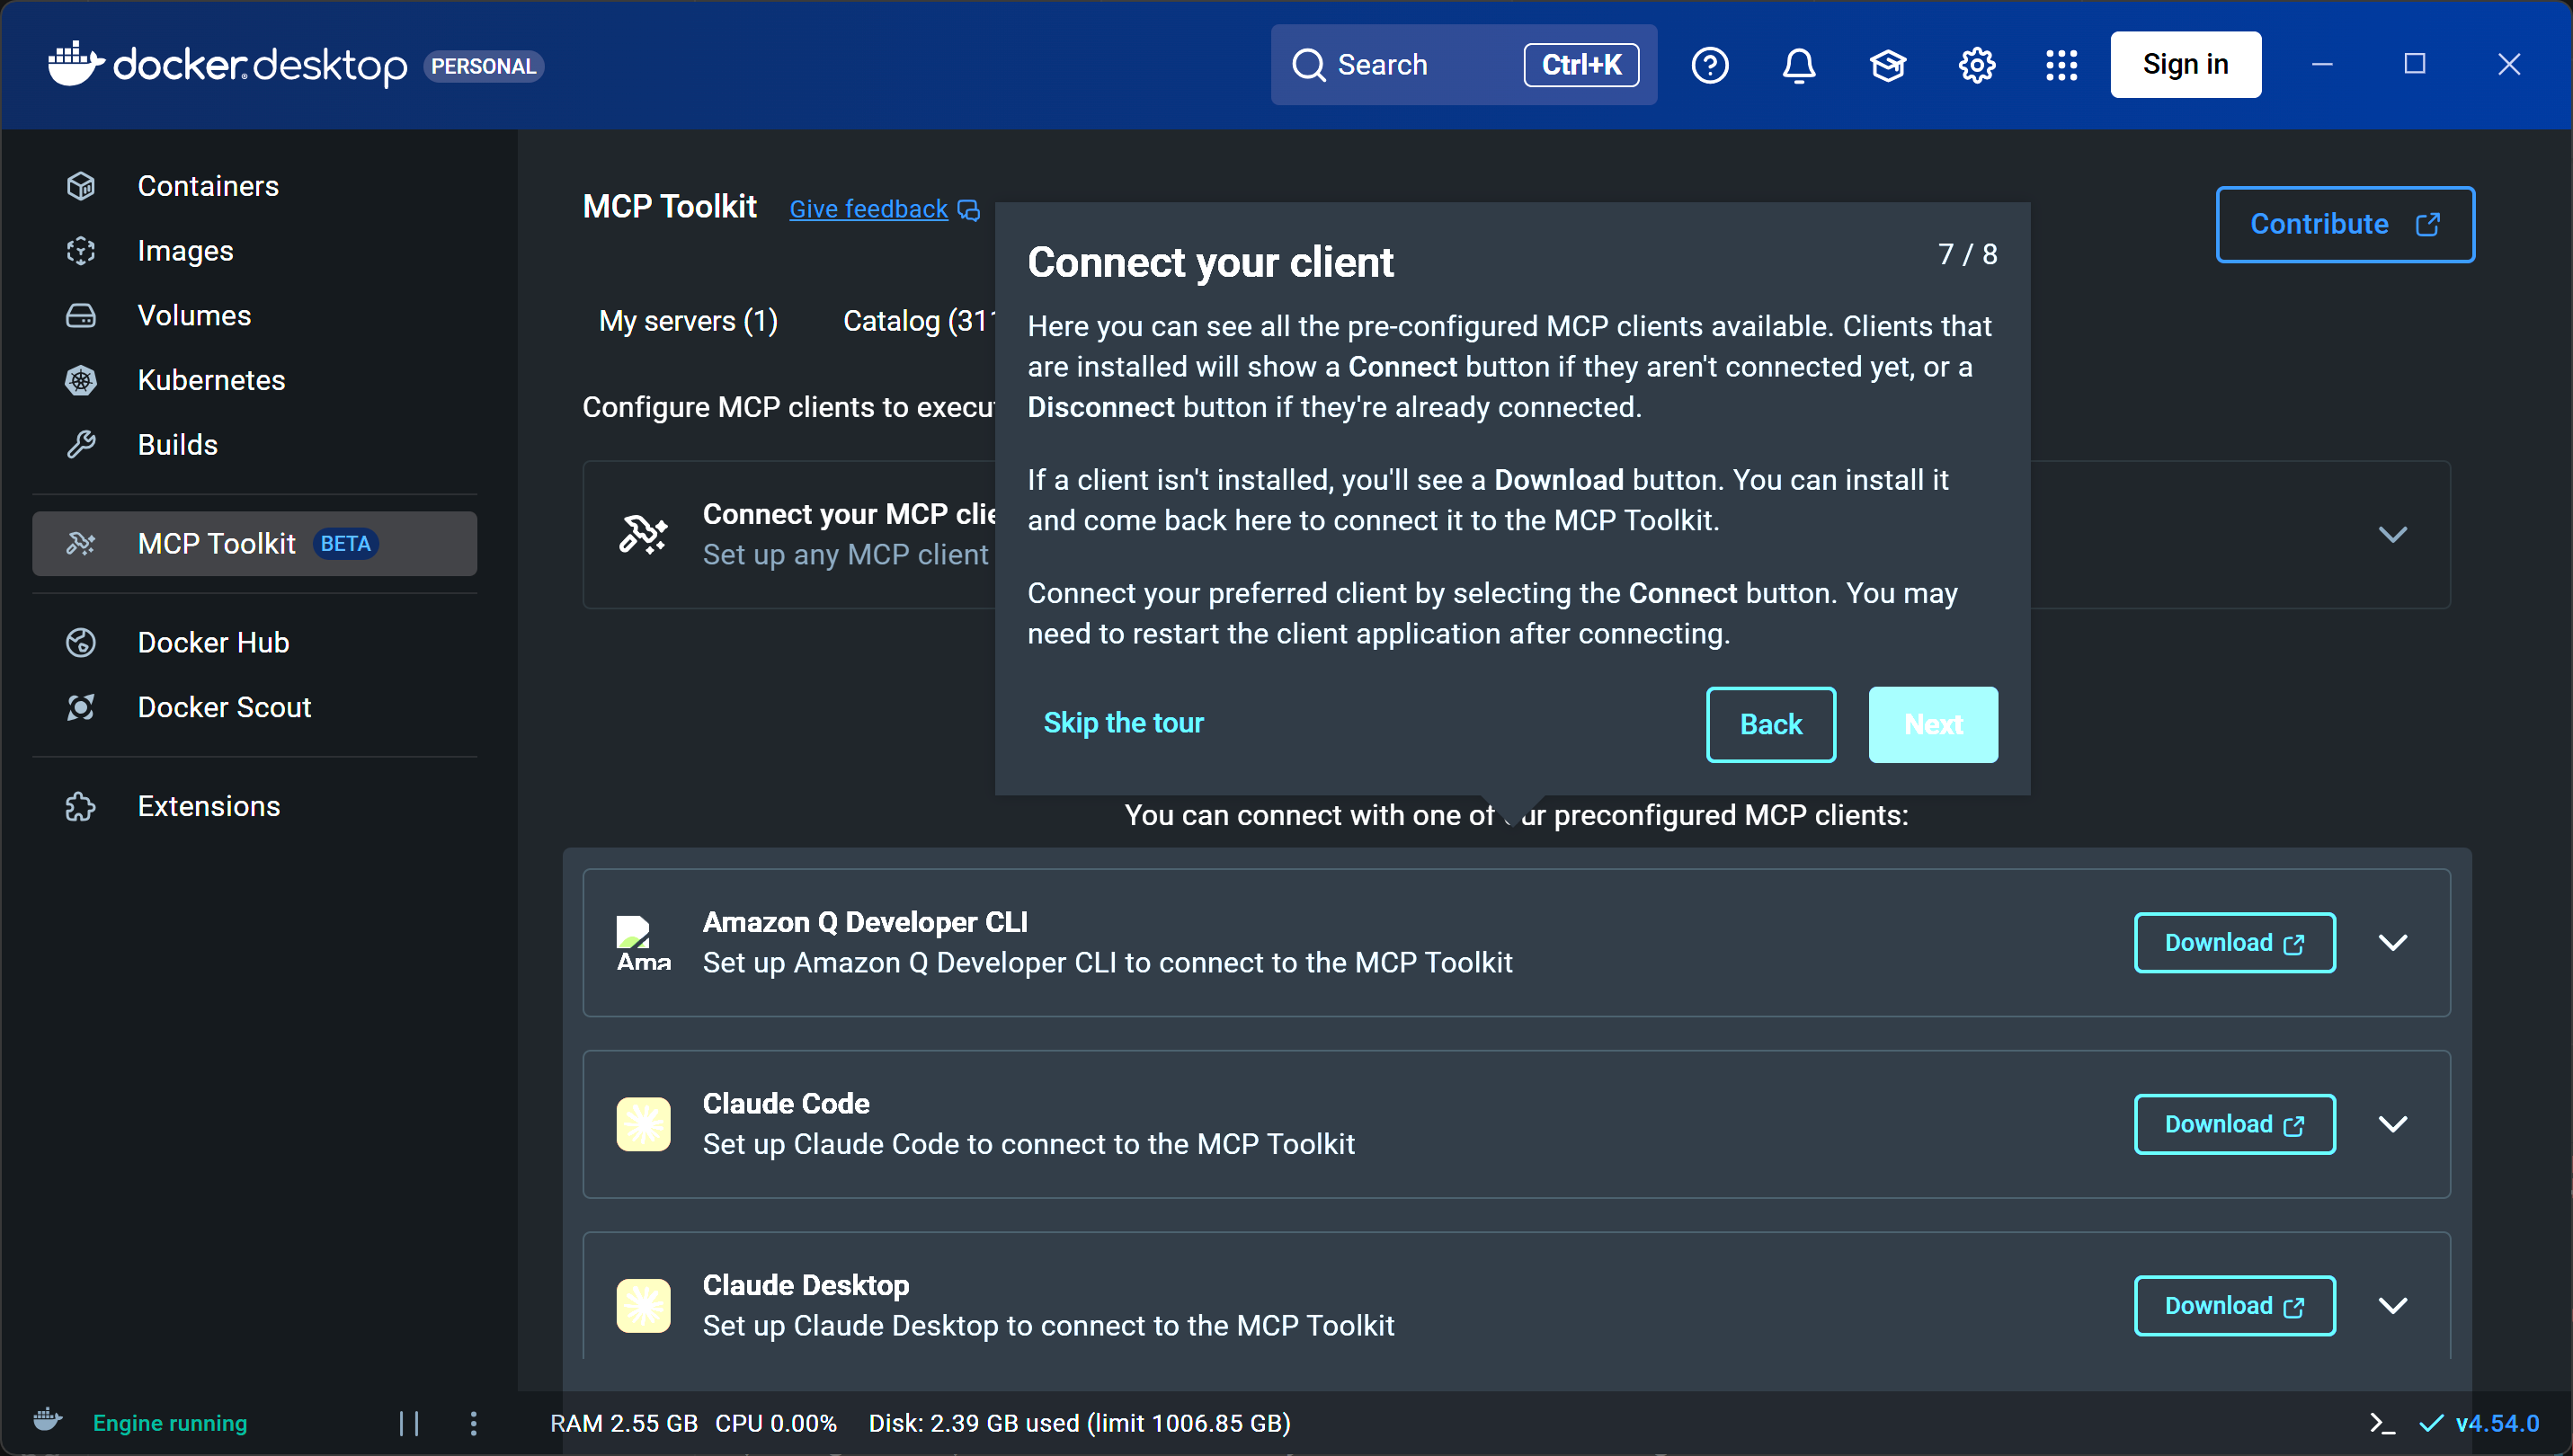
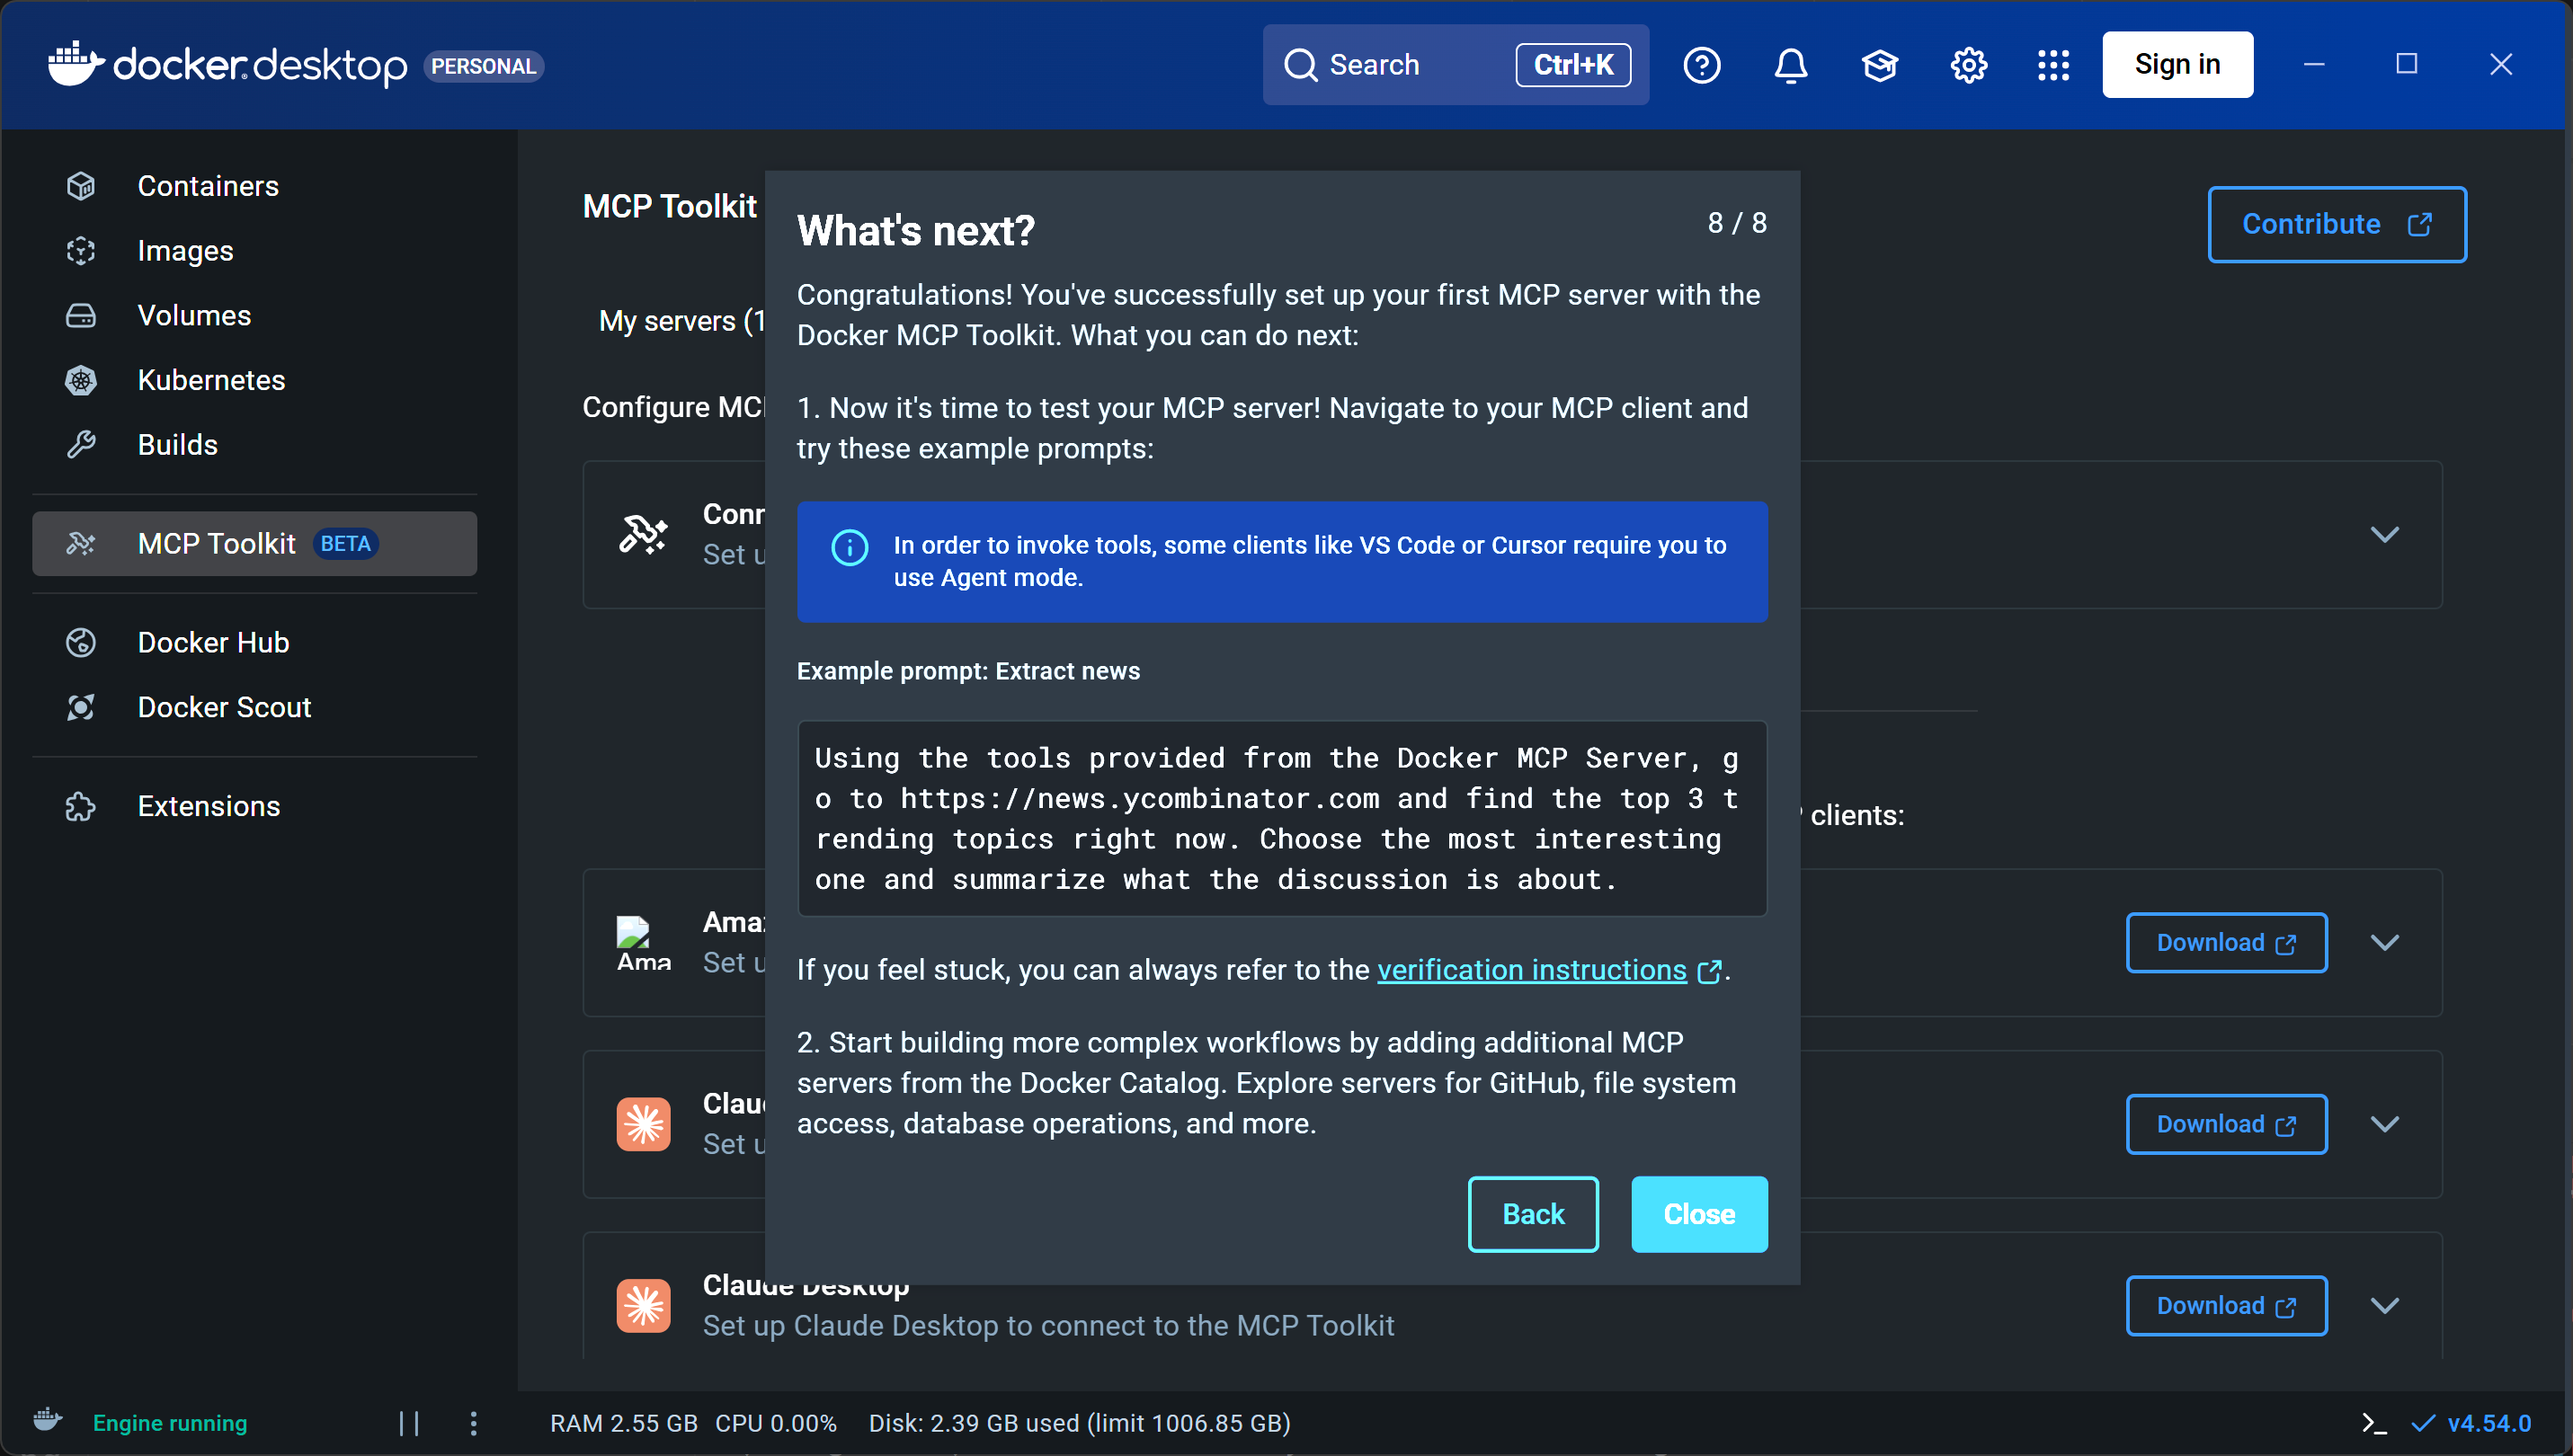

## 3.3 使用Cherry Studio开发MCP应用



### 3.3.1 MCP服务配置与集成

#### 3.3.1.1 安装与初始化
1. **启动Cherry Studio**：
   ```bash
   cherry-studio --port 8080
   ```
2. 访问 http://localhost:8080 并登录
3. 进入"插件市场"安装"MCP协议支持"插件

#### 3.3.1.2 配置本地MCP服务
1. 进入"服务管理" → "添加服务"
2. 选择服务类型："自定义MCP服务"
3. 配置服务信息：
   - 服务名称："本地MCP服务"
   - 服务URL：http://localhost:8000
   - 超时时间：30秒
4. 点击"测试连接"，显示"连接成功"后保存

### 3.3.2 智能体创建与函数配置

#### 3.3.2.1 创建MCP智能体
1. 进入"智能体" → "新建智能体"
2. 选择模板："MCP协议智能体"
3. 基本信息配置：
   - 名称："客户分析智能体"
   - 描述："基于MCP协议的客户分群与销售预测"
   - 图标：客户分析相关图标
4. 点击"创建"完成基础配置

#### 3.3.2.2 导入MCP函数
1. 进入智能体详情页，切换到"函数"标签
2. 点击"导入函数" → "从MCP服务导入"
3. 选择已配置的"本地MCP服务"
4. 勾选需要导入的函数：
   - customer_segmentation
   - sales_forecast
5. 点击"导入"，系统自动加载函数定义

## 3.4 课程作业与实践

### 3.4.1 作业要求
开发一个完整的客户分析MCP应用，包含：
1. **功能要求**：
   - 客户分群与销售预测
   - 批量数据导入与处理
   - 分析结果可视化展示
   - 结果导出为Excel格式

2. **技术要求**：
   - 使用Cherry Studio设计协作流程
   - 实现MCP服务与至少2个函数
   - 支持本地和ModelScope模型切换
   - 处理至少100条客户数据

### 3.4.2 提交内容
- Cherry Studio流程设计截图
- MCP服务核心代码（mcp_service.py）
- 测试数据与执行结果
- 技术总结报告（500字以内）